Added code to HNN-Core to enable probabilistic application of tonic bias to model direct cell stimulation with TMS. Code added in network.py (Network.add_tonic_bias() and _add_cell_type_bias()), network_builder.py (NetworkBuilder._create_cells_and_drives()), and cell.py (Cell.create_tonic_bias()).

A random number generator object is attached to the bias object itself so that probability results are reproducible with a set seed. Numbers are pulled from this generator as the NetworkBuilder is attaching the bias to each cell to independently determine which cells are stimulated. A caveat of this is that a different approach will be necessary for multiple-pulse TMS, as which cells are stimulated by each pulse will not be entirely independent. Naive approach e.g. randomly flagging each cell as a responder or nonresponder to TMS.

Another caveat is that the tonic bias doesn't allow for any timing jitter, which would happen in real cells, but might not be worth worrying about.

In [1]:
import os.path as op

import matplotlib.pyplot as plt
%matplotlib ipympl

import hnn_core
from hnn_core import jones_2009_model, simulate_dipole, read_params
from hnn_core.network_models import add_erp_drives_to_jones_model
from hnn_core.viz import NetworkPlotter
from copy import deepcopy


In [2]:
def drive_sim(mesh_shape=(1, 1), clear_connectivity=True, direct=None, tstop=50, trace=True, movie=False):
    net = jones_2009_model(mesh_shape=mesh_shape)
    if clear_connectivity:
        net.clear_connectivity() # To isolate the effects of the stimulation

    # Note that we move the cells further apart to allow better visualization of
    # the network (default inplane_distance=1.0 µm).
    net.set_cell_positions(inplane_distance=300)
    
    if direct is not None:
        # Add direct w/ cell-type specific probability
        net.add_tonic_bias(**direct)

    dpl = simulate_dipole(net, tstop=tstop, record_vsec='all')

    if trace:
        fig, ax = plt.subplots()
        times = net.cell_response._times
        vsec = net.cell_response._vsec[0]
        for cell in vsec.values(): ax.plot(times, cell['soma'])
        ax.legend(['L2_basket', 'L2_pyramidal', 'L5_basket', 'L5_pyramidal'])
        # print(net.cell_response.spike_times)
    if movie:
        net_plot = NetworkPlotter(net)  # Reinitialize plotter with simulated network
        net_plot.xlim = (400, 1600)
        net_plot.ylim = (400, 1600)
        net_plot.zlim = (-500, 1600)
        net_plot.azim = 225
        if type(movie) is str:
            net_plot.export_movie(f'tonic_bias_testing/{movie}.gif', dpi=100, fps=30, interval=100)
        else:
            net_plot.export_movie('tonic_bias_testing/tms_direct.gif', dpi=100, fps=30, interval=100)
        return net_plot

In [3]:
direct = dict(
    bias_name="tms_direct",
    t0=0.5, # Tune
    tstop=0.8, # Tune
    amplitude=      {'L2_basket':    2, 
                     'L2_pyramidal': 10, 
                     'L5_basket':    2,
                     'L5_pyramidal': 30}, # Tune to mimic real cell response 
    probability=    {'L2_basket':    0.01,
                     'L2_pyramidal': 0.01,
                     'L5_basket':    0.01,
                     'L5_pyramidal': 0.01}, # Tune
)

Amplitudes are tuned to produce fast spikes

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...


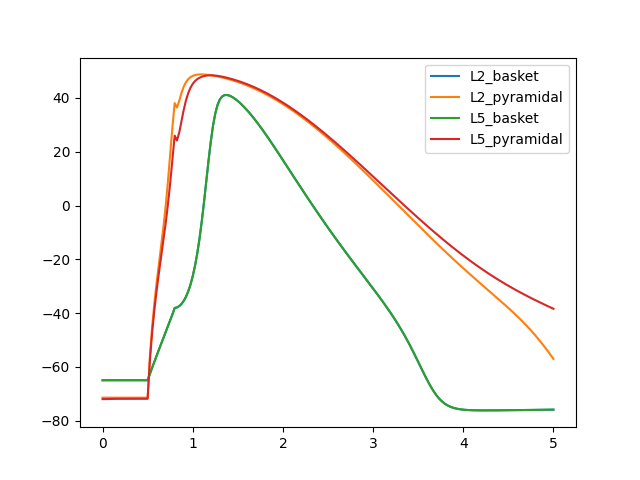

In [8]:
direct_c = deepcopy(direct)
direct_c['probability'] = 1.
net_plot = drive_sim(mesh_shape=(1, 1), 
                     clear_connectivity=True, 
                     direct=direct_c, 
                     tstop=5, 
                     trace=True, 
                     movie=False)

Stimulation produces bursting, even just above threshold

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...


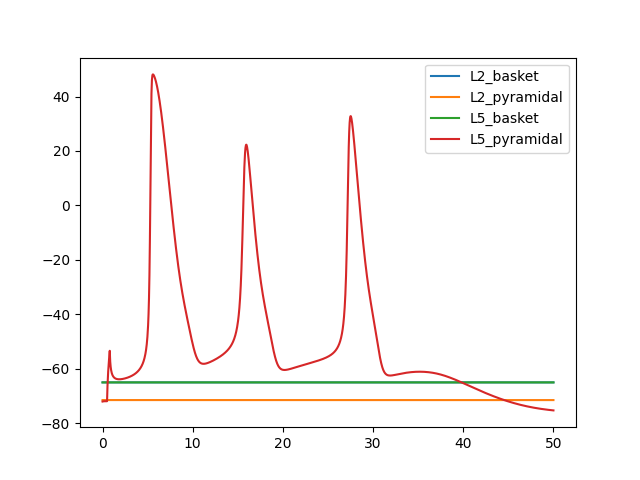

In [17]:
direct_c = deepcopy(direct)
direct_c['amplitude']['L5_pyramidal'] = 7
direct_c['probability']['L5_pyramidal'] = 1.
net_plot = drive_sim(mesh_shape=(1, 1), 
                     clear_connectivity=True, 
                     direct=direct_c, 
                     tstop=50, 
                     trace=True, 
                     movie=False)

Tonic bias works in network configuration

C:\Users\jacob\Documents\Thesis\hnn_tms_direct\hnn_core\dipole.py:77: UserWarning: No connections instantiated in network. Consider using net = jones_2009_model() or net = law_2021_model() to create a predefined network from published models.
  warnings.warn(


Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...


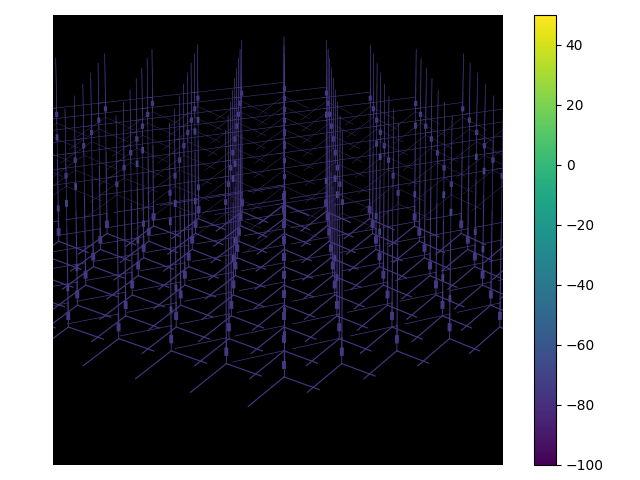

In [18]:
direct_c = deepcopy(direct)
direct_c['probability'] = 1.
net_plot = drive_sim(mesh_shape=(10, 10), 
                     clear_connectivity=True, 
                     direct=direct_c, 
                     tstop=50, 
                     trace=False, 
                     movie='tonic_bias_1')

Probability param works as intended

C:\Users\jacob\Documents\Thesis\hnn_tms_direct\hnn_core\dipole.py:77: UserWarning: No connections instantiated in network. Consider using net = jones_2009_model() or net = law_2021_model() to create a predefined network from published models.
  warnings.warn(


Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...


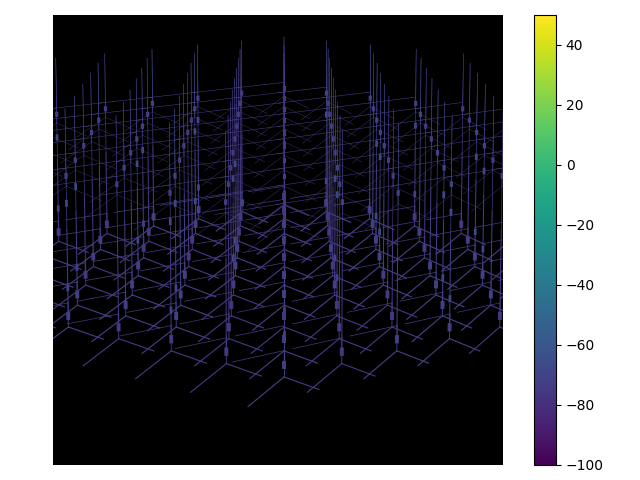

: 

In [ ]:
direct_c = deepcopy(direct)
direct_c['probability'] = 0.5
net_plot = drive_sim(mesh_shape=(10, 10), 
                     clear_connectivity=True, 
                     direct=direct_c, 
                     tstop=50, 
                     trace=False, 
                     movie='tonic_bias_0-5')

Connecting the network, all stimulated cells spike, then the L5 Pyr cells spike once again. Could be due to bursting dynamics, stimulation from L2 Pyr, or both. There is no third spike, however, due to the inhibition.

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from C:\Users\jacob\Documents\Thesis\hnn_tms_direct\hnn_core\mod\nrnmech.dll
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...


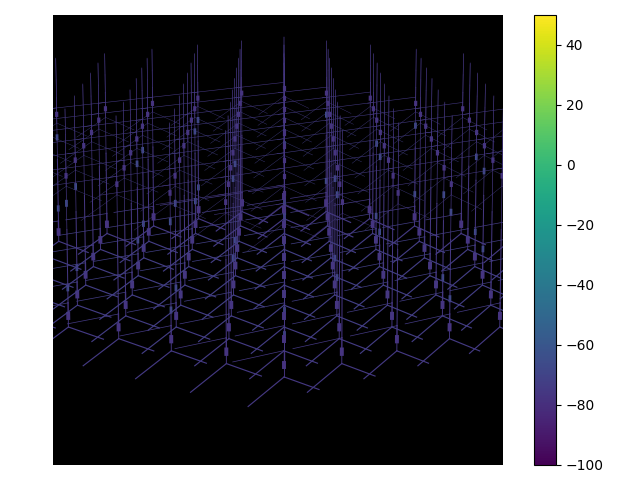

In [5]:
direct_c = deepcopy(direct)
direct_c['probability'] = 1.
net_plot = drive_sim(mesh_shape=(10, 10), 
                     clear_connectivity=False, 
                     direct=direct_c, 
                     tstop=50, 
                     trace=False, 
                     movie='connected_direct_1')

Same results as above in trace

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...


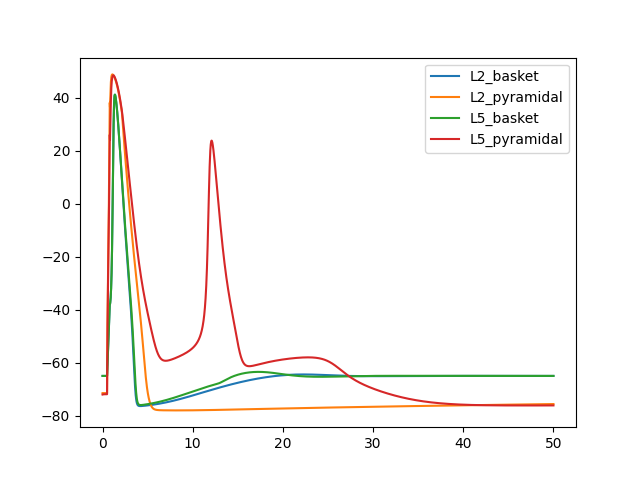

In [6]:
direct_c = deepcopy(direct)
direct_c['probability'] = 1.
net_plot = drive_sim(mesh_shape=(1, 1), 
                     clear_connectivity=False, 
                     direct=direct_c, 
                     tstop=50, 
                     trace=True, 
                     movie=False)

Much richer and longer-lasting propagating dynamics when only half of each cell type is stimulated. The L5 Pyr cells that received the initial stimulus spike twice, and some of the other L5 Pyr cells are then synaptically activated and spike multiple times.

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...


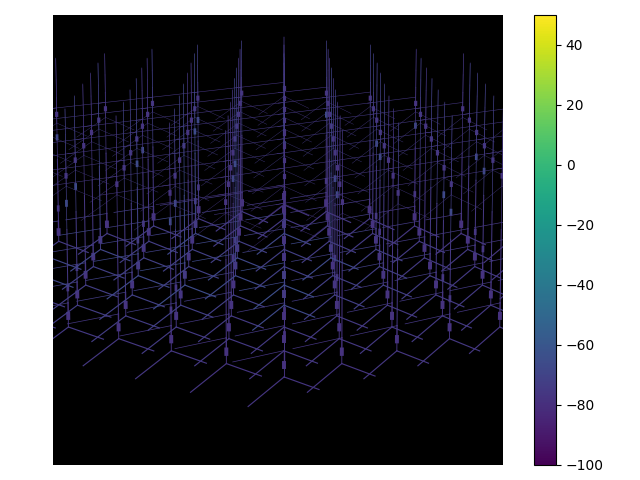

In [7]:
direct_c = deepcopy(direct)
direct_c['probability'] = 0.5
net_plot = drive_sim(mesh_shape=(10, 10), 
                     clear_connectivity=False, 
                     direct=direct_c, 
                     tstop=50, 
                     trace=False, 
                     movie='connected_direct_0-5')